In [ ]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [ ]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Generating the target function and its noisy version.

Geramos 30 amostras da seguinte função objetivo

$$y = 1 + 0.5 x + 2 x^2$$

In [ ]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*x**2

# Noise.
w = np.sqrt(0.09)*np.random.randn(N, 1)

# Noisy function.
y_noisy = y + w

# Validation samples.
Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + np.sqrt(0.09)*np.random.randn(Ntest, 1)

In [ ]:
print('Média das amostras da função observável:', np.mean(y_noisy))

Média das amostras da função observável: 1.530915117847102


**Observação**

+ A média de $y_{noisy}$ é igual a $1.531$, pois sua esperança é igual a $1 + 2 \big(\frac{1}{3}\big)$.


+ Isso de deve ao fato do atributo $x^2$ ter esperança igual a $\frac{1}{3}$ e o atributo $x$ e o ruído $w$ terem esperanças iguais a zero, respectivamente.

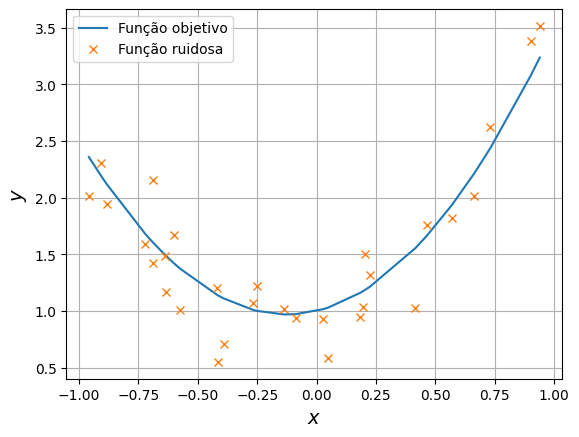

In [ ]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)

#Show the plot.
plt.show()

### Define the polinomial order

In [ ]:
# Polynomial order.
model_order = 15

### Define a list of regularization factors to be tested

In [ ]:
# Regularization factor.
lambdas = [0, 0.656, 100000]

### Ridge regression with SciKit-Learn

Usamos a classe `Ridge` para realizar a regressão Ridge.

A biblioteca SciKit-Learn tem diferentes *solvers* para implementar a regressão Ridge.

O *solver* `cholesky` implementa a solução de forma fechada.

Já os *solvers* `sag` e `saga` implementam versões baseadas no gradiente descendente.

Por padrão, o *solver* é escolhido automaticamente baseado no tipo de dado usado.

Porém, existem outros solvers. Verifique a documentação da classe Ridge, a qual pode ser acessada através do link abaixo:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

**Observações**

+ É importante escalonar os atributos (por exemplo, usando a classe StandardScaler) antes de executar a regressão Ridge, pois ela é especialmenre sensível à escala dos atributos.


+ O parâmetro `alpha` da classe `Ridge` é o fator de regularização, $\lambda$, e não o passo de aprendizagem.

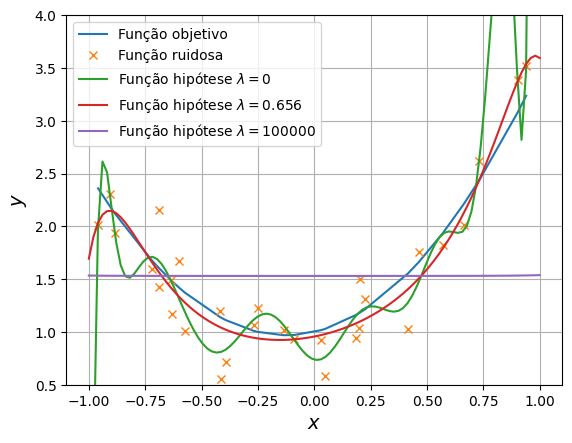

In [ ]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i])
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Predict.
    y_test_regul = model.predict(x_test)
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Função hipótese $\lambda=$'+str(lambdas[i]))

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
#plt.savefig("ridge_regression.png", dpi=600)

#Show the plot.
plt.show()

#### Conclusões

+ Com $\lambda=0$, regressão Ridge se torna uma regressão polinomial sem regularização.


+ Conforme $\lambda$ aumenta, o modelo não se **contorce** tanto e passa a capturar o comportamento da função objetivo (**modelo se torna menos flexível**).


+ Se $\lambda$ continuar aumentando, todos os pesos acabarão muito próximos de zero e o resultado será uma **reta que passa pela média dos dados de treinamento**, ou seja, o valor do peso de bias.


+ O aumento de $\lambda$ leva a hipóteses menos complexas. Isso reduz a variância do modelo, mas aumenta seu viés. Ou seja, ele tende a subajustar.


+ Conforme $\lambda$ aumenta, os pesos e a norma L2 do vetor de pesos diminuem.


+ Podemos utilizar técnicas de validação cruzada para encontrar o valor ideal de $\lambda$.

### Weight variation versus lambda (i.e., regularization factor)

Cria uma sequência de 10000 valores linearmente espaçados para o fator de regularização, variando de $1e^{-3}$ até $100$.

In [ ]:
M = 10000
lambdas = np.linspace(1e-3, 100, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i])
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[0,0:model_order]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)

    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

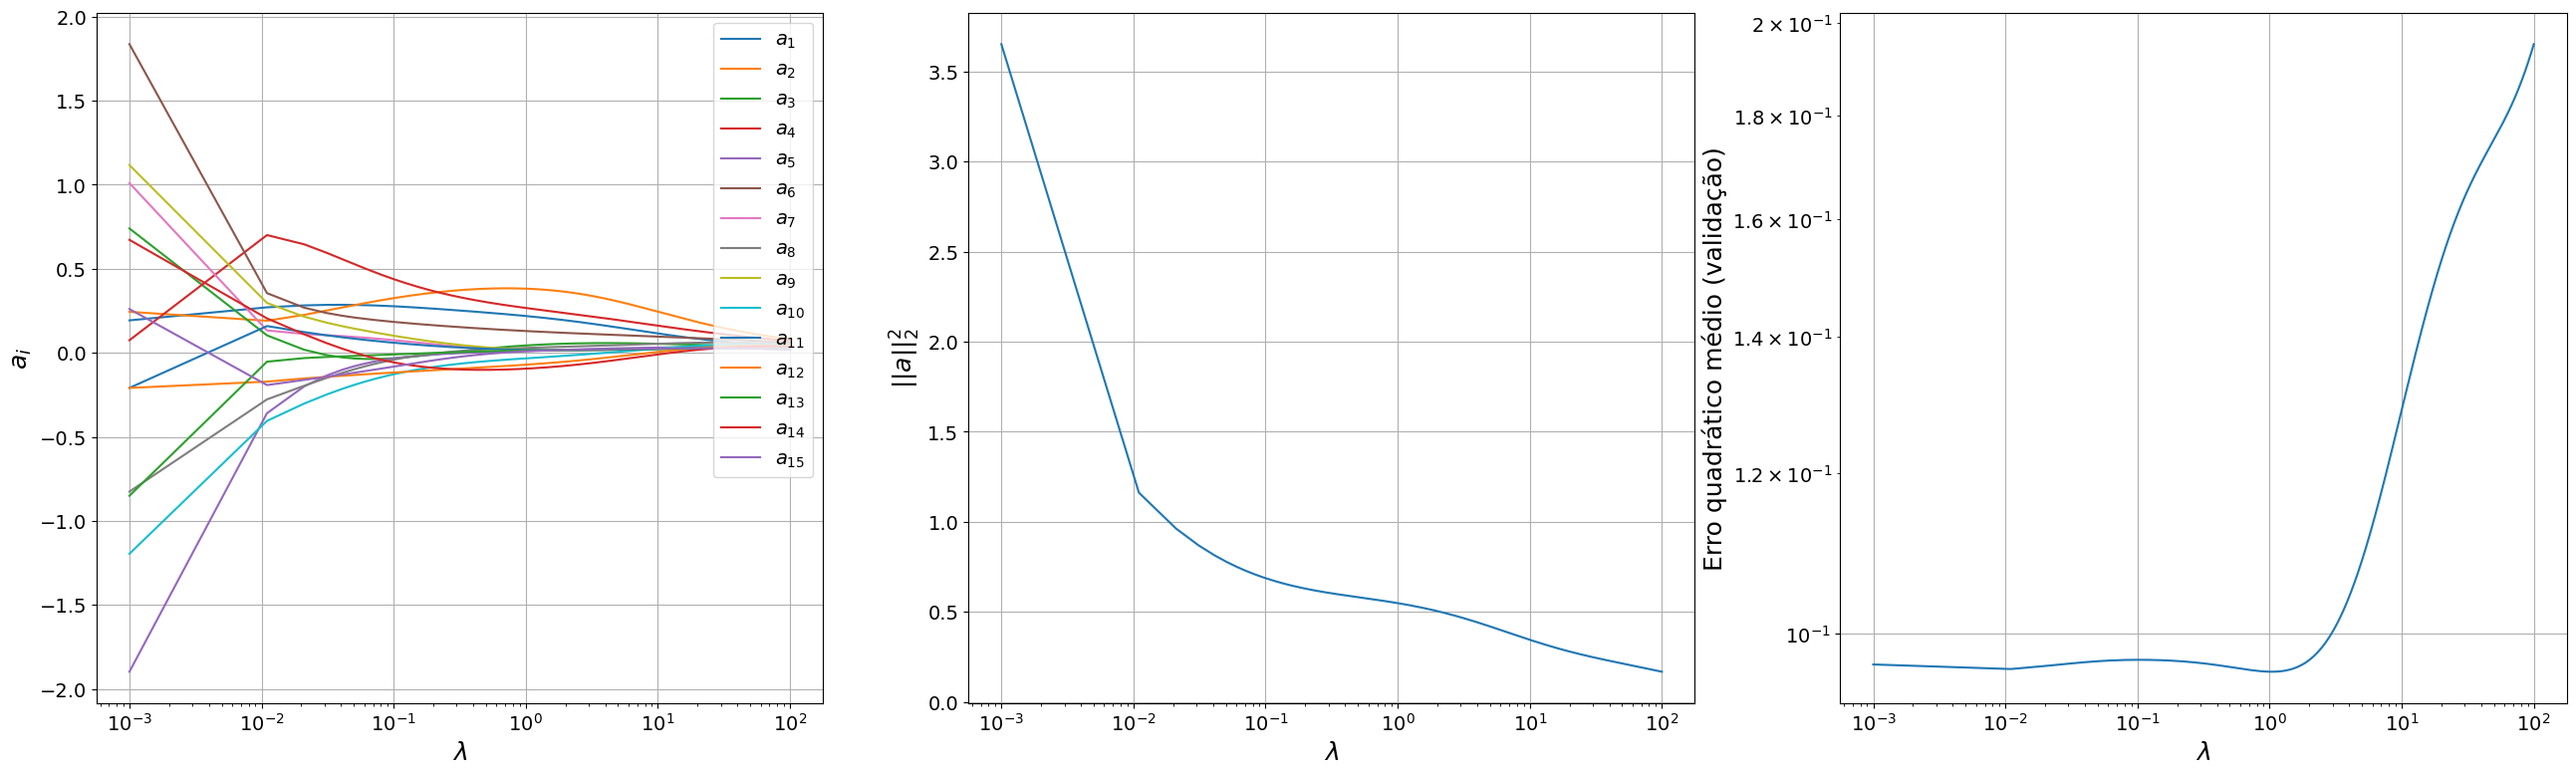

In [ ]:
# Create figure.
fig = plt.figure(figsize=(32,9))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0, model_order):
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_2^2$', fontsize=18)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio (validação)', fontsize=18)
plt.grid()

#Show the plot.
plt.show()

ax.tick_params(reset=True)

Conforme o valor de $\lambda$ aumenta, o valor dos pesos diminui, **mas eles só zeram para valores muito grandes de $\lambda$**.

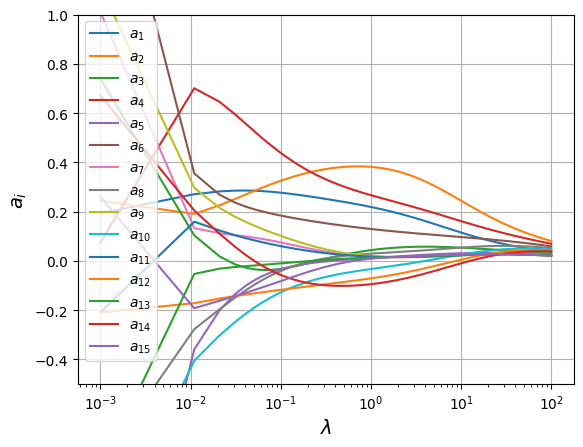

In [ ]:
# Plot weight.
for i in range(0,model_order):
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.ylim([-0.5, 1])
plt.grid()
#Show the plot.
plt.show()

### Using cross-validation for finding the best $\lambda$

Usamos a classe `RidgeCV` para encontrar o valor ideal de $\lambda$.

#### Ajuste grosso

Geramos 10000 valores espaçados uniformemente em uma escala logarítmica, no intervalo de $10^{-5}$ a $10^2$.

In [ ]:
M = 10000
alphas = np.logspace(-5, 2, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=False)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())

Pipeline(steps=[('poly', PolynomialFeatures(degree=15, include_bias=False)),
                ('scaler', StandardScaler()),
                ('reg',
                 RidgeCV(alphas=array([1.00000000e-05, 1.00161327e-05, 1.00322914e-05, ...,
       9.96781250e+01, 9.98389328e+01, 1.00000000e+02]),
                         scoring='neg_mean_squared_error'))])

In [ ]:
clf['reg'].alpha_

0.6553625918127431

#### Ajuste fino

Geramos 10000 valores linearmente espaçados.

In [ ]:
alphas = np.linspace(clf['reg'].alpha_/10, clf['reg'].alpha_*10, M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=False)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())

Pipeline(steps=[('poly', PolynomialFeatures(degree=15, include_bias=False)),
                ('scaler', StandardScaler()),
                ('reg',
                 RidgeCV(alphas=array([0.06553626, 0.06618513, 0.06683401, ..., 6.55232817, 6.55297704,
       6.55362592]),
                         scoring='neg_mean_squared_error'))])

In [ ]:
clf['reg'].alpha_

0.656011465666023

### Comparing the results

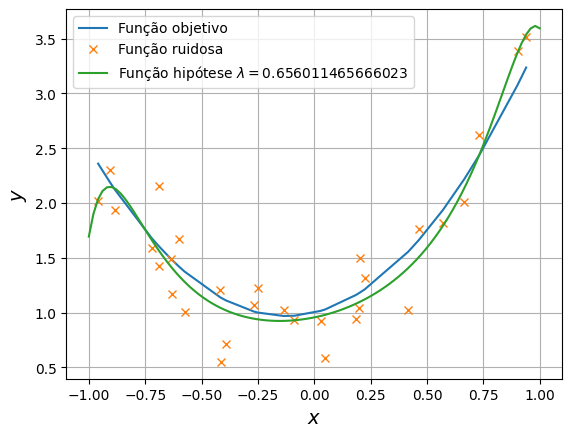

In [ ]:
y_test_pred = clf.predict(x_test)

# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.plot(x_test, y_test_pred, label='Função hipótese $\lambda=$'+str(clf['reg'].alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()